In [235]:
%matplotlib inline
import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt

## Noise Variance Learning

In [236]:
def ECNOISE(x_b, F, M, N):

    # x_b: a base point in domain; must be a column vector
    # F: function with noise we wish to estimate
    # M: number of points sampled along a curve; must have M>/2
    # N: dimension of domain of f
    
    # Throw an error for not sampling enough points
    if M<2:
        return print('Please select M=2 or larger.')
    
    # Initialize storage for difference table
    T = np.zeros((M,M))
    
    # We pick a direction to sample in, and normalize it:
    p = np.ones((N,1))/np.sqrt(N)
    
    # Form difference table
    for i in range(0,M):
        T[i,0] = F(x_b + (i/M)*p)

    for j in range(0,M-1):
        for i in range(0,M-j-1):
            T[i,j+1] = T[i+1,j] - T[i,j]
            
    # Make a row vector to store the k-level estimators (sigma_k^2) 
    S = np.zeros((1,M))
    
    # Build S according to paper; each k-th component of S is the k-th level estimator for the variance in our noise
    # which is computed using a scaled average of the k-th level difference values, from the difference table T
    for i in range(1,M):
        S[0,i] = ((np.math.factorial(i)**2.)/np.math.factorial(2*i))*(1./(M-i))*np.sum(T[:,i]**2,axis=0)

    S=S[:,1:] # Don't need the first column (because first col. of T just holds function values!)
    
    possible_estimator = np.sum(S[:,2:4], axis=1)/3
    est_var = possible_estimator
    
    return [S, est_var[0]]

## Lipschitz Constant Learning

In [238]:
def LIPS(F, M, N, est_var):
    
    # F: noisy function we wish to obtain an estimate of L_! for
    # M: number of times we wish to draw points and estimate L_1
    # N: dimension of inputs
    # est_var: the estimated variance of the noise in f
    
    # We need to estimate max ||f''|| roughly and cheaply
    
    # Constants we need
    std=est_var**0.5
    eps_star=3*std
    
    # Take a random draw
    x_0=10*(2*np.random.rand(N,1) - np.ones((N,1)))

    # Define an arbitrary unit vector
    unit_v=np.ones((N,1))/(N**(1/N))
    
    # Step size
    h=std**0.25

    # Computes a centered finite difference to approximate f'' at x_0
    F_m=F(x_0 - h*unit_v)
    F_0=F(x_0)
    F_p=F(x_0 + h*unit_v)
    diff = abs(F_p - 2*F_0 + F_m)

    # Our guess for ||f''||
    mu_f2=diff/(N*h**2)
    
    # Now we will take draws and estimate L_1
    
    x_vals=np.zeros((N,1)) # matrix to store the vectors we randomly make
    grads=np.zeros((N,1)) # matrix to store the gradients we approximate
    ratios=np.zeros((M,1)) # vector storing the ratios we are intersted in!
    h_star=(8**0.25)*np.sqrt(std/mu_f2) # the prescribed step size by Chen/More

    for j in range(0,M):

        # Take two draws inside a large hypercube and store them
        x=100*(2*np.random.rand(N,1) - np.ones((N,1)))
        y=100*(2*np.random.rand(N,1) - np.ones((N,1)))
        x_vals=np.hstack((x_vals,x))
        x_vals=np.hstack((x_vals,y))

        # For loop to make finite diff approx's 
        # to each partial and form approx gradient at x
        approx_grad_x=np.zeros((N,1))
        for i in range(0,N):
            e = np.zeros((N,1))
            e[i] = 1.0
            approx_grad_x[i] = (F(x + h_star*e) - F(x))/h_star
    
        # Store the gradient at x
        grads=np.hstack((grads,approx_grad_x))
    
        # For loop to make finite diff approx's 
        # to each partial and form approx gradient at y
        approx_grad_y=np.zeros((N,1))
        for p in range(0,N):
            e = np.zeros((N,1))
            e[p] = 1.0
            approx_grad_y[p] = (F(y + h_star*e) - F(y))/h_star
    
        # Store the gradient at y
        grads=np.hstack((grads,approx_grad_y))
    
        # Form ratios to estimate L_1
        # Note we subtract by 2*eps_star, which was mentioned in Callies paper
        diff_1=np.linalg.norm(approx_grad_x - approx_grad_y) - 2*eps_star
        diff_2=np.linalg.norm(x-y)
        r=diff_1/diff_2
        ratios[j]=r
    
    x_vals=x_vals[:,1:]
    grads=grads[:,1:]
    
    # Take most pessimistic draw?
    L_1_est=(np.max(ratios))

    #print('the ratios are', np.transpose(ratios),'and our estimate to L_1 is', L_1_est)
    return [L_1_est]
    
    
    

## STARS

In [239]:
def STARS(x_init,F, mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # mu_star: smoothing parameter
    # h: step length
    
    # Evaluate noisy F(x_init)
    f = F(x_init)
    
    # Draw a random vector of same size as x_init
    u = np.random.normal(0,1,(N,1))
    
    # Form vector y, which is a random walk away from x_init
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x)
    
        
    return [x, f, y, g]

## STARSRV

In [240]:
def STARSRV(x_init,F,u ,mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # u: Choice of random vector; probably comes from active subspace
    # note that lower f's are evaluations of F(*)
    # k: noise parameter
    # mu_star: smoothing parameter
    # h: step length
    

    
    # Evaluate noisy F(x_init)
    f = F(x_init)
    
    
    # Form vector y, which is a random walk away from x_init
    # in the direction of u, which the user defines
    sclr=np.random.normal(0,1)
    u=sclr*u
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x)
    
        
    return [x, f, y, g]

## Active Subspace Learning

In [303]:
def ACT(x_hist, f_hist):
    
    # x_hist: history of x values - x's are transposed and stored as rows in array x_hist
    # f_hist: history of f values - f's are real-valued an stored as rows in a column vector f_hist
    
    # Compute AS using function values stored in f_hist
    
    # Instantiate a subspace object
    ss = ac.subspaces.Subspaces()

    # Use Local Linears
    # df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    # ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')
    
    ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
    ac.utils.plotters.sufficient_summary(x_hist.dot(ss.W1), f_hist)

    return [ss.eigenvecs[0], ss.eigenvals[0]]

## Example 1. Noisy 1 dimensionally active function.


Let $f: R^N \to R$ with additive noise, $$f(x; \xi)=x_i^2 + \epsilon (\xi),$$ where $\epsilon \sim U[-k,k]$ is stoachastic additive noise with zero mean and bounded variance $k^2/3$. Then we have $\nabla f(x)=2(0,\ldots,0,x_i,0,\ldots,0)$ and one can show that $L_1^*=2$. This means that the value of $||\nabla f(x) -\nabla f(y)||$ will never be larger than twice the value of $2||x-y||$. Note $f$ has a one-dimensional active subspace given by span$(e_i)$ where $e_i$ is the $i$-th standard basis vector.

In [304]:
N=40 # this is the dimension of the inputs!

# Noise level
k=1e-3

# Pick an index i: 0 <= i <= N
ind=20

def act1(x):
    return (x[ind]**2 + k*(2*np.random.rand(1) - 1))[0]

x_test=np.ones(N)
x_test[ind]=4

print('Noisy function evaluated at x_test is', act1(x_test), 'and the error-free value is', x_test[ind]**2)

Noisy function evaluated at x_test is 16.000316307343127 and the error-free value is 16.0


### Call ECNoise and estimate noise variance

In [305]:
sphere_noise = ECNOISE(np.ones((N,1)), act1, 6, N)
est_var1=sphere_noise[1]

print(est_var1)

2.9837985435626375e-07


### Learn L_1

In [306]:
act1_lips = LIPS(act1, 6, N, est_var1)
L_1_est1 = act1_lips[0]

print(L_1_est1)

0.5957463589486144


### Perform STARS (full variables)

In [307]:
# STARS optimal hyperparameters

mu_star1=((8*est_var1*N)/(L_1_est1**2*(N+6)**3))**0.25
h1=1/(4*L_1_est1*(N+4))

print(mu_star1,h1)

0.007250714365269812 0.009537310797577636


In [308]:
x_init1=100*(2*np.random.rand(N,1) - np.ones((N,1)))

print(np.shape(x_init1),act1(x_init1))

(40, 1) 9161.455317018323


In [332]:
# Run pure STARs

x=x_init1
f=act1(x)

x_hist=np.array(x)
f_hist1=np.array(f)

maxit=75

for i in range(1, maxit):
    s=STARS(x,act1,mu_star1,h1)
    x=s[0]
    f=s[1]
    x_hist=np.hstack((x_hist,x))
    f_hist1=np.vstack((f_hist1,f))
    
print(np.linalg.norm(x),f)

353.1358066616329 566.482459826882


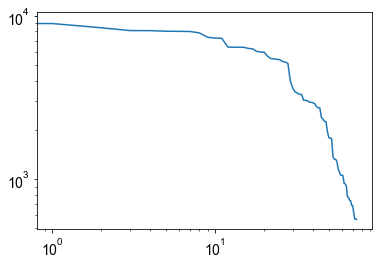

In [333]:
plt.loglog(f_hist1)
plt.show()

## Example 2. Our previous function, but from $\mathbb{R}$ to $\mathbb{R}$

In [311]:
# Noise level
k=1e-3

def act2(x):
    return(x[0]**2 + k*(2*np.random.rand(1) - 1))[0]

x_test=[9]

print('Noisy function evaluated at x_test is', act2(x_test))

Noisy function evaluated at x_test is 81.00052122002845


### Call ECNoise and estimate noise variance

In [312]:
ellip_noise = ECNOISE([1], act2, 6, 1)
est_var2=ellip_noise[1]

print(est_var2)

2.922608148014149e-08


### Learn L_1

In [313]:
ellip_act2 = LIPS(act2, 10, 1, est_var2)
L_1_est2 = ellip_act2[0]

print(L_1_est2)

2.0028959307038496


### Perform STARS (full variables)

In [314]:
# STARS optimal hyperparameters

mu_star2=((8*est_var2*1)/(L_1_est2**2*(1+6)**3))**0.25
h2=1/(4*L_1_est2*(1+4))

print(mu_star2,h2)

0.003610459039651285 0.024963853205507886


In [315]:
x_init2=[np.sqrt(act1(x_init1))]

print(act2(x_init2))

9161.455634714372


In [316]:
# Run pure STARs

x=x_init2
f=act2(x)

x_hist=np.array(x)
f_hist2=np.array(f)

maxit=75

for i in range(1, maxit):
    s=STARS(x,act2,mu_star2,h2)
    x=s[0]
    f=s[1]
    x_hist=np.vstack((x_hist,x))
    f_hist2=np.hstack((f_hist2,f))
    
print(np.linalg.norm(x),f)

580.3836729971467 5.237996574752497


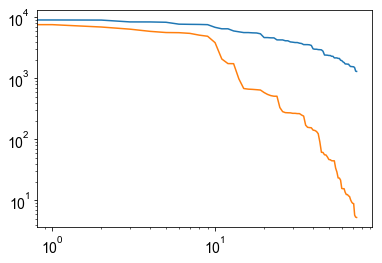

In [317]:
plt.loglog(f_hist1)
plt.loglog(f_hist2)
plt.show()

## Example 3: Use STARSRV on Example 1 function

In [318]:
# Run STARSRV

x=x_init1
f=act1(x)

x_hist=np.array(x)
f_hist3=np.array(f)

# Let's choose the direction we know f is active in
u=np.zeros((N,1))
u[ind]=1

maxit=75

for i in range(1, maxit):
    s=STARSRV(x, act1, u, mu_star1, h1)
    x=s[0]
    f=s[1]
    x_hist=np.hstack((x_hist,x))
    f_hist3=np.vstack((f_hist3,f))
    
print(np.linalg.norm(x),f)

362.7763009447609 1180.2163207758963


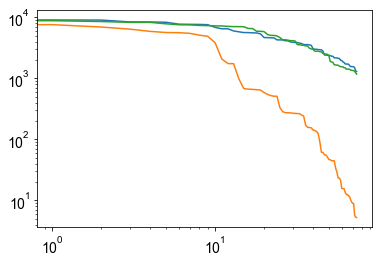

In [319]:
plt.loglog(f_hist1)
plt.loglog(f_hist2)
plt.loglog(f_hist3)
plt.show()

## Example 4: Try to Learn Active Subspace of Example 1 function

In [320]:
x_0=100*(2*np.random.rand(N,1) - np.ones((N,1)))
x_hista=np.array(x_0)
f_hista=np.array(act1(x_0))
for i in range(1,1000):
    x=100*(2*np.random.rand(N,1) - np.ones((N,1)))
    x_hista=np.hstack((x_hista, x))
    f_hista=np.vstack((f_hista, act1(x)))

n should be an integer. Performing conversion.


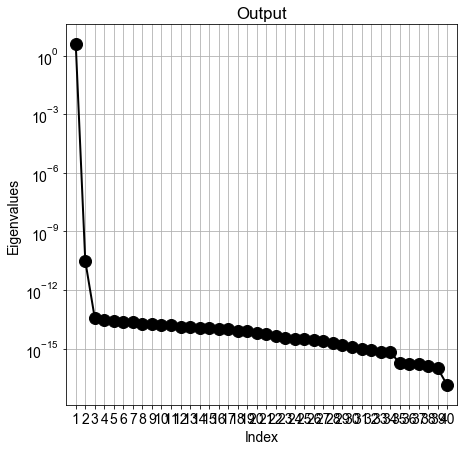

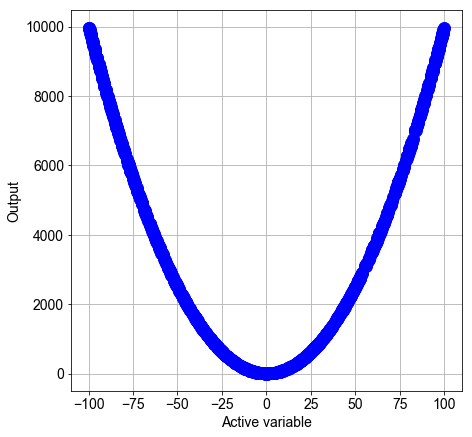

[array([2.26765225e-09, 5.04367571e-02, 2.46164105e-01, 1.17812492e-02,
       1.06003874e-01, 6.82979577e-02, 8.18445564e-02, 7.13246075e-02,
       1.28758809e-01, 1.71148601e-01, 0.00000000e+00, 1.66947890e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.53450023e-01,
       0.00000000e+00, 0.00000000e+00, 2.27324907e-01, 0.00000000e+00,
       3.60248286e-01, 2.61484217e-01, 0.00000000e+00, 0.00000000e+00,
       1.61303566e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.30115964e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.45899559e-01, 0.00000000e+00, 0.00000000e+00,
       4.24515422e-01, 6.87234824e-02, 0.00000000e+00, 0.00000000e+00]), array([3.99999994])] the ind-th component of the first eigenvector is 0.3602482858692981 but the largest component in that vector is 33


In [321]:
ans=ACT(np.transpose(x_hista), f_hista)

print(ans, 'the ind-th component of the first eigenvector is', ans[0][ind], 'but the largest component in that vector is', np.argmax(ans[0]))

In [322]:
# Run STARSRV

x=x_init1
f=act1(x)

x_hist=np.array(x)
f_hist4=np.array(f)

# Let's choose the direction of the first eigenvector, above
u=ans[0]

maxit=75

for i in range(1, maxit):
    s=STARSRV(x, act1, u, mu_star2, h2)
    x=s[0]
    f=s[1]
    x_hist=np.hstack((x_hist,x))
    f_hist4=np.vstack((f_hist4,f))
    
print(np.linalg.norm(x),f)

2362.94778733313 9161.454574772351


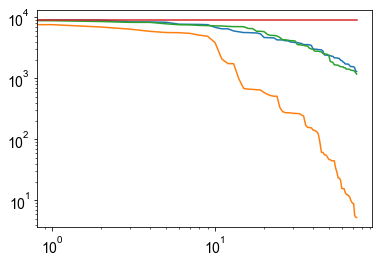

In [323]:
plt.loglog(f_hist1)
plt.loglog(f_hist2)
plt.loglog(f_hist3)
plt.loglog(f_hist4)
plt.show()